This notebook is by Anastasia Ruzmaikina.

In this notebook we use PyTorch Neural Networks to analyze the data set of 6497 wines. 

We use eleven characteristics of the wine such as 'fixed acidity', 'volatile acidity', 'citric acid',
'residual sugar', 'chlorides', etc. to predict the quality of the wine, graded from 0 to 9.
       
We use Linear Regression using simplified PyTorch Neural Networks with several dense layers and ReLU activation functions. The methods used in this notebook come from the course on PyTorch from Machine Leaning University on machinelearningplus.com.

The most accurate predictions come from the neural networks with large number of hidden layers and a large size of hidden layers. For example a six layer neural network with hidden_size = 300 has 65.23% accuracy of prediction on the test set, and a four layer neural network with hidden_size = 400 has 62.77% accuracy of prediction on the test set.

First we import several Pytorch libraries.

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from torch.autograd import Variable

Then import some necessary Python Libraries.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

Finally we import the tools from Scikit learn.

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report, r2_score

In [99]:
from IPython.display import display, HTML
display(HTML("<style>.container ( width:100% !important; )</style>"))

In [100]:
!mkdir Checkpoint  #directory for checkpoints

mkdir: Checkpoint: File exists


We upload a file wine1.csv and look at the data.

In [101]:
data = pd.read_csv("wine1.csv")
data

,Unnamed: 0.1,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,high_quality
0,0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
1,1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0
2,2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0
3,3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,1
4,4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6492,4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,1
6493,6493,4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,0
6494,6494,4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,1
6495,6495,4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,1


The columns 'Unnamed: 0.1' and 'Unnamed: 0' carry no information and should be dropped.

The column 'color' can be replaced with one hot encoding, but for simplicity we drop it.

The column 'high_quality' is determined by the column 'quality' (any wine with quality 6 or more is considered high quality), so we drop this column, because it cannot be used to predict 'quality'. 

In [102]:
#color_dummies= pd.get_dummies(data=data, columns=['color'])
#data = color_dummies
data.drop(['Unnamed: 0.1'], axis=1, inplace = True)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.drop(['high_quality'], axis = 1, inplace = True)
data.drop(['color'], axis = 1, inplace = True)
print(data.columns)
data.head()

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We can look at the column statistics.



In [103]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


To check the distribution of variables, we plot histograms of variables to find if they are normal or skewed.

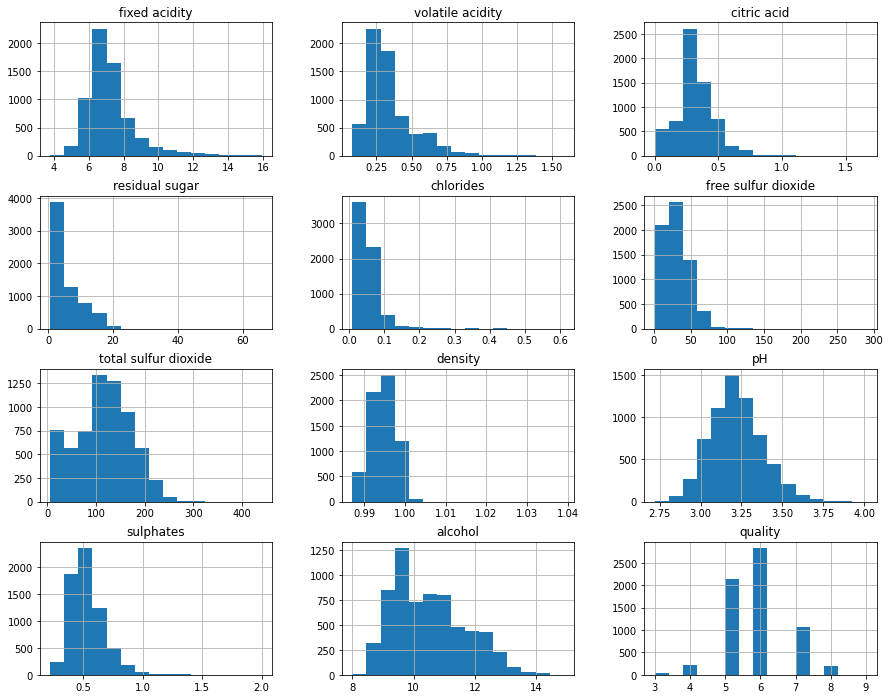

In [104]:
# plot histograms of the variables
params = data

params.hist(figsize=(15,12),bins = 15)

plt.show()

In order to make sure that a column with larger values of data does not influence the predicted 'quality' more than other columns, we use the Standard Scaler to standardize the first eleven columns.

In [8]:
# standardize features by removing the mean and scaling to unit variance
data.iloc[:, 0:11] = StandardScaler().fit_transform(data.iloc[:, 0:11])
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,5
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,5
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,6
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818,6
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766,5
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,6
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402,7


We split the data into a training set and the test set.

In [9]:
train_x, test_x, train_y, test_y =train_test_split(data.iloc[:,:-1], data.iloc[:,-1].values, train_size=0.9)

We need to reshape the training data and the test data as a PyTorch tensor. We do this for the X values first.

In what follows the training set of X is called X_data and the test set of x is called test_x.

In [10]:
X_data = Variable(torch.Tensor(np.array(train_x).reshape(5847,11)))
test_x = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))

X_data

tensor([[-0.2432, -0.9091,  0.2159,  ..., -1.3590,  0.6635,  0.1746],
        [-0.0889,  1.5206, -2.1240,  ...,  2.0619,  0.3947, -0.5801],
        [-1.7089,  4.1327, -1.9176,  ...,  3.3059, -0.3446,  0.0069],
        ...,
        [-0.1661, -1.0914,  0.0094,  ..., -0.0529, -1.2855, -1.0832],
        [-0.3204, -0.9091,  1.7987,  ..., -0.6127, -0.3446, -0.7478],
        [ 0.2196, -0.6662,  2.4869,  ..., -1.4212, -1.0166, -1.4186]])

Next we reshape the y data as a PyTorch tensor. 

We call the training set y_data and we call the test set test_y.

In [11]:
y_data = Variable(torch.Tensor(np.array(train_y).reshape(5847,1)))
test_y = Variable(torch.Tensor(np.array(test_y).reshape(650,1)))
print(y_data)
print(test_y)

tensor([[6.],
        [5.],
        [4.],
        ...,
        [5.],
        [6.],
        [5.]])
tensor([[6.],
        [7.],
        [6.],
        [6.],
        [6.],
        [7.],
        [7.],
        [6.],
        [7.],
        [5.],
        [6.],
        [6.],
        [5.],
        [6.],
        [5.],
        [4.],
        [5.],
        [8.],
        [5.],
        [6.],
        [6.],
        [6.],
        [5.],
        [6.],
        [6.],
        [5.],
        [7.],
        [6.],
        [7.],
        [5.],
        [6.],
        [5.],
        [6.],
        [5.],
        [5.],
        [6.],
        [7.],
        [6.],
        [5.],
        [7.],
        [5.],
        [6.],
        [6.],
        [8.],
        [6.],
        [6.],
        [7.],
        [5.],
        [6.],
        [5.],
        [8.],
        [6.],
        [5.],
        [6.],
        [5.],
        [6.],
        [7.],
        [6.],
        [7.],
        [6.],
        [6.],
        [6.],
        [5.],
        [6.],
      

We wish to predict y using X_data. To train the model, we first try a Neural Network with one dense layer.

The loss function is minimized using the mean squared error loss criterion.

The weights are optimized using the stochastic gradient descent.

In [12]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(11,1)
    def forward(self, x):
        predict_y = self.linear(x)
        return predict_y

It turns out the the one layer model diverges except for very small learning rates. Here we take the learning rate to be 0.00001.

In [12]:
model = LinearRegression()
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


To minimize the cost function, we iterate the model for 4,500,000 iterations, using Stochastic Gradient Descent to update the weights of model on every step. 

In [13]:
list = []
for epoch in range(4500000):
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 32.98029327392578
epoch 10000, cost function 22.15682601928711
epoch 20000, cost function 14.991762161254883
epoch 30000, cost function 10.218046188354492
epoch 40000, cost function 7.0274481773376465
epoch 50000, cost function 4.8915324211120605
epoch 60000, cost function 3.460456371307373
epoch 70000, cost function 2.501174211502075
epoch 80000, cost function 1.8580435514450073
epoch 90000, cost function 1.4266633987426758
epoch 100000, cost function 1.137281060218811
epoch 110000, cost function 0.9430647492408752
epoch 120000, cost function 0.8126274943351746
epoch 130000, cost function 0.7251449227333069
epoch 140000, cost function 0.6663652658462524
epoch 150000, cost function 0.6269102692604065
epoch 160000, cost function 0.6002833843231201
epoch 170000, cost function 0.5824505090713501
epoch 180000, cost function 0.5702704787254333
epoch 190000, cost function 0.5621980428695679
epoch 200000, cost function 0.5566715002059937
epoch 210000, cost function 0.55

epoch 1740000, cost function 0.5443003177642822
epoch 1750000, cost function 0.5443003177642822
epoch 1760000, cost function 0.5443003177642822
epoch 1770000, cost function 0.5443003177642822
epoch 1780000, cost function 0.5443003177642822
epoch 1790000, cost function 0.5443003177642822
epoch 1800000, cost function 0.5443003177642822
epoch 1810000, cost function 0.5443003177642822
epoch 1820000, cost function 0.5443003177642822
epoch 1830000, cost function 0.5443003177642822
epoch 1840000, cost function 0.5443003177642822
epoch 1850000, cost function 0.5443003177642822
epoch 1860000, cost function 0.5443003177642822
epoch 1870000, cost function 0.5443003177642822
epoch 1880000, cost function 0.5443003177642822
epoch 1890000, cost function 0.5443003177642822
epoch 1900000, cost function 0.5443003177642822
epoch 1910000, cost function 0.5443003177642822
epoch 1920000, cost function 0.5443003177642822
epoch 1930000, cost function 0.5443003177642822
epoch 1940000, cost function 0.544300317

epoch 3450000, cost function 0.5443003177642822
epoch 3460000, cost function 0.5443003177642822
epoch 3470000, cost function 0.5443003177642822
epoch 3480000, cost function 0.5443003177642822
epoch 3490000, cost function 0.5443003177642822
epoch 3500000, cost function 0.5443003177642822
epoch 3510000, cost function 0.5443003177642822
epoch 3520000, cost function 0.5443003177642822
epoch 3530000, cost function 0.5443003177642822
epoch 3540000, cost function 0.5443003177642822
epoch 3550000, cost function 0.5443003177642822
epoch 3560000, cost function 0.5443003177642822
epoch 3570000, cost function 0.5443003177642822
epoch 3580000, cost function 0.5443003177642822
epoch 3590000, cost function 0.5443003177642822
epoch 3600000, cost function 0.5443003177642822
epoch 3610000, cost function 0.5443003177642822
epoch 3620000, cost function 0.5443003177642822
epoch 3630000, cost function 0.5443003177642822
epoch 3640000, cost function 0.5443003177642822
epoch 3650000, cost function 0.544300317

We plot the cost function as a function of the number of iterations. As you can see, it decreases quickly at first, then very slowly. After about 1,600,000 iterations the value of the cost function stops changing.

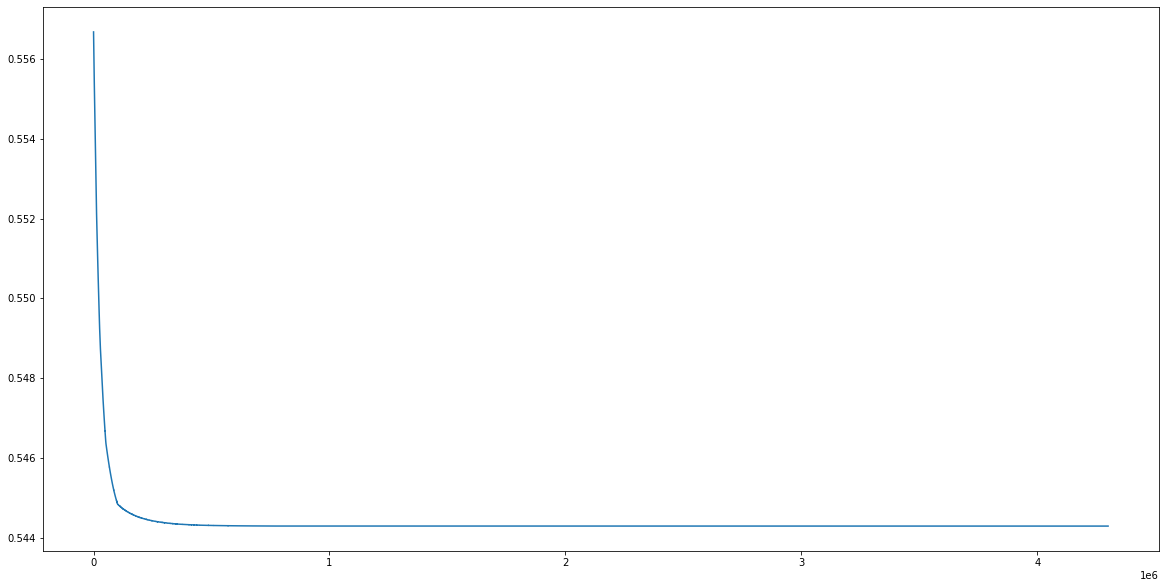

In [14]:
plt.figure(figsize = (20,10))
plt.plot(list[200000:])

We use the final model to predict the y values using the training set of X_data.

We then convert our predictions into integers between 0 and 9.

In [15]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[6 5 6 ... 6 5 6]


Next we use the final model to predict the y values using the test set of X called test_x.

We then convert our predictions into integers between 0 and 9.

We graph both the predicted values of y and the actual test values of y.

[6 6 6 6 6 5 6 5 6 6 5 6 6 6 6 6 6 6 5 5 7 5 6 6 5 6 5 6 5 6 7 6 6 6 7 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 5 6 5 6 5 5 6 6 6 5 5 6 6 6 5 6 6 6 6 6 6 5 6 5 6
 5 5 6 6 6 6 6 5 6 5 5 6 6 5 7 6 6 6 6 6 7 5 6 6 6 5 7 6 6 6 6 5 6 6 5 5 6
 6 6 5 5 6 6 6 5 6 6 7 6 5 5 6 5 5 6 5 5 5 6 6 6 6 6 6 6 5 5 6 6 5 6 5 5 5
 6 6 6 6 5 6 6 6 6 6 6 6 5 5 6 6 6 6 5 6 5 5 6 6 6 6 6 7 6 6 5 6 5 7 6 6 6
 6 6 6 6 6 5 6 6 6 6 6 6 7 6 6 6 6 6 6 6 7 5 6 6 6 6 5 5 5 6 5 5 6 6 6 6 6
 6 6 6 6 6 5 6 5 5 5 6 5 6 6 6 7 6 6 6 6 6 6 6 6 6 5 6 5 6 6 5 6 7 6 6 7 6
 5 7 6 6 6 6 7 6 6 6 6 6 6 6 5 6 5 6 6 5 5 6 5 5 6 6 6 5 5 7 5 5 6 5 6 6 7
 6 5 6 6 5 6 7 5 5 6 6 6 6 5 5 6 6 6 6 5 5 6 6 6 6 6 6 6 7 6 6 6 6 6 6 5 5
 5 6 7 5 5 7 6 6 6 5 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 5 7 5 6 6 5 6 5 6 5 6 6
 6 6 6 6 6 6 6 5 5 7 5 5 5 6 6 6 6 7 6 6 6 6 6 6 6 6 6 5 5 5 5 5 6 6 6 6 6
 5 6 5 6 5 5 7 6 6 6 5 6 5 6 6 5 5 6 5 6 6 5 5 6 6 6 5 5 7 6 7 6 6 6 5 6 7
 6 6 5 7 5 5 6 6 6 5 6 5 5 6 5 5 6 5 5 6 5 7 6 6 5 5 6 6 6 6 6 7 7 6 6 6 5
 6 7 6 5 5 5 5 5 5 6 5 6 

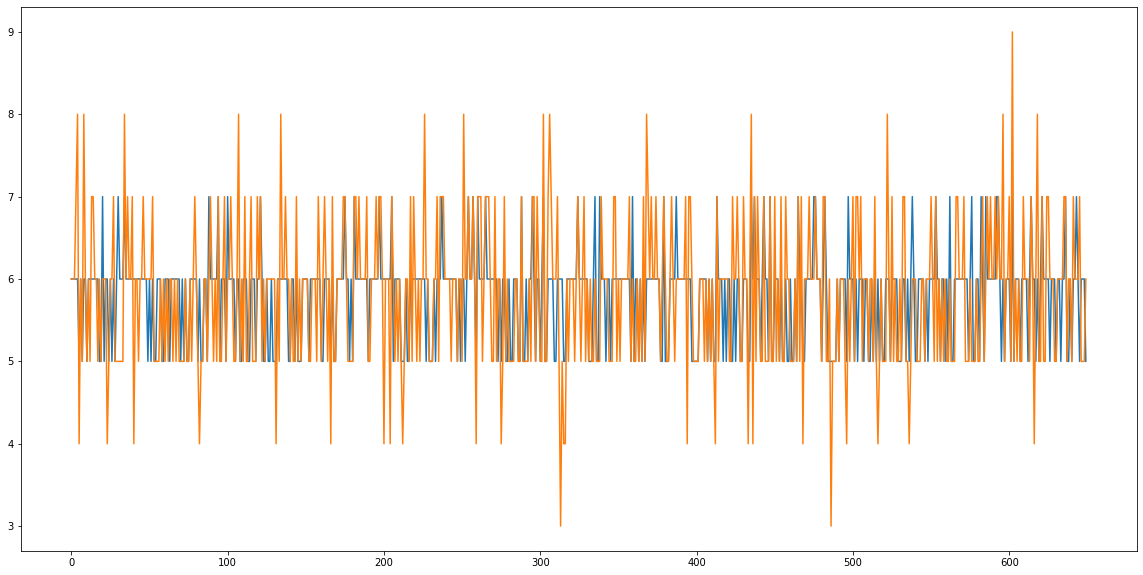

In [16]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for the predicted values of y for both the training set and the test set.

In [17]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-np.array(pred_train_y))**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-np.array(test_y))**2))))

train RMSE 1.0378489358835383
test RMSE 1.0344183398292723


We calculate the R2 score for the predicted values of y for both the training set and the test set.

In [18]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( np.array(test_y), pred_y))

train R2 score:  0.15990458360677595
test R2 score:   0.19539214358301626


Next we calculate the Mean Absolute Percentage Error.

In [19]:
print("train MAPE {} ".format(np.mean(np.abs((y_data.detach().numpy()-pred_train_y))/y_data.detach().numpy())))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-np.array(test_y))/np.array(test_y)))))

train MAPE 0.13429240516449711 
test MAPE 0.1352888813750352 


Finally, we get the percentage of accurate predictions for both the training set and the test set.

In [20]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print(n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print(n*100/len(pred_y), "%")

53.343595005985975 %
53.84615384615385 %


Notice, that the test set has only 54% accuracy of predictions. It is not possible to improve accuracy for this model, because the loss function stopped decreasing.

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In order to get a higher accuracy of predictions, we need to use a more complicated model, so that it can learn our dataset better.

Two layer model is the next simplest model after one layer model.

In order to introduce more features, which allows the model to learn more information, we make a model with two dense layers.

The first dense layer has input dimension equal to eleven (since X has eleven columns) and the output dimension equal to the hidden_size. The second dense layer has input dimension equal to the hidden_size and output dimension equal to one (because y has one column).

In [64]:
class TwoLayerNeuralNet(nn.Module):  #fully connected neural network with two hidden layers
    def __init__(self, num_features, hidden_size, num_classes):
        super(TwoLayerNeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)    
        return out 


We take the hidden_size to be 500, so that the neural network can store more information.

The cost function we are trying to minimize is the usual mean squared error loss used in linear regression.

We use stochastic gradient descent to change weights.

In [27]:
model = TwoLayerNeuralNet(11, 500, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

TwoLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We run the optimization for 200000 iterations. 

In [28]:
list = []
for epoch in range(200000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 32.97993850708008
epoch 10000, cost function 0.4660186469554901
epoch 20000, cost function 0.4406379461288452
epoch 30000, cost function 0.4247515797615051
epoch 40000, cost function 0.41255509853363037
epoch 50000, cost function 0.4023168683052063
epoch 60000, cost function 0.3929840326309204
epoch 70000, cost function 0.3843095898628235
epoch 80000, cost function 0.3760407269001007
epoch 90000, cost function 0.3681155741214752
epoch 100000, cost function 0.36049214005470276
epoch 110000, cost function 0.35322362184524536
epoch 120000, cost function 0.34635820984840393
epoch 130000, cost function 0.3398325741291046
epoch 140000, cost function 0.33366164565086365
epoch 150000, cost function 0.3276926577091217
epoch 160000, cost function 0.3218245506286621
epoch 170000, cost function 0.3161640167236328
epoch 180000, cost function 0.3107740879058838
epoch 190000, cost function 0.30550822615623474


We graph the cost function as a function of the number of iterations.

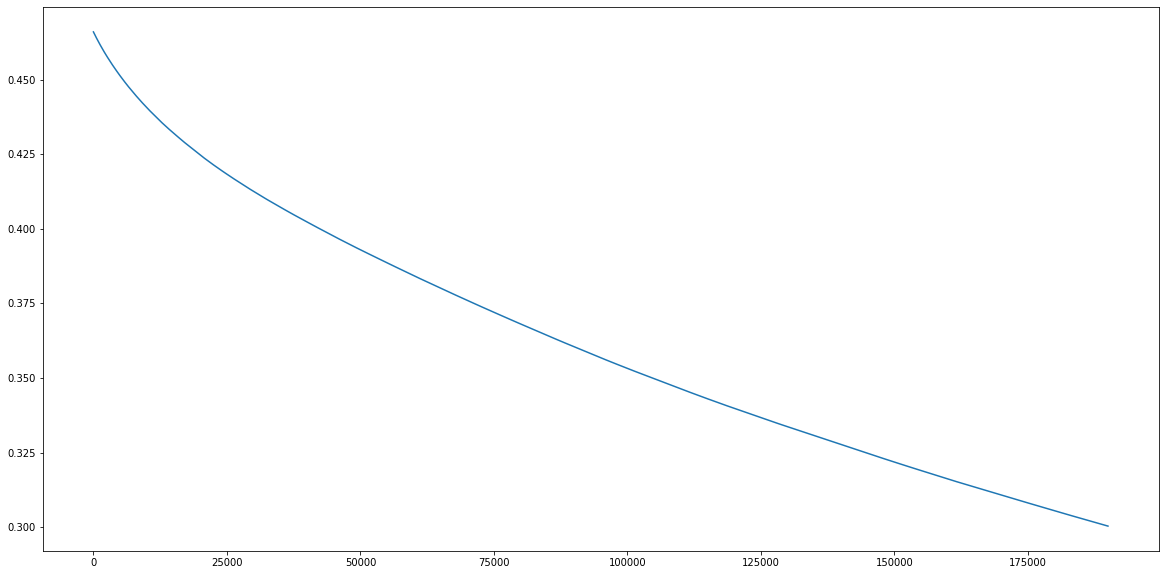

In [29]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We get the predictions of y on the training set of X_data using the final model. 

We translate those y values into integers 0 to 9 and store them in numpy array pred_train_y.

In [30]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[5 5 6 ... 6 7 6]


We get the predictions of y on the test set of X (test_x) using the final model. 

We translate those y values into integers 0 to 9 and store them in numpy array pred_y.

We the graph both the predicted values of y and actual values of y in the test set.

[ 5  6  6  6  5  6  5  7  5  6  6  6  7  6  5  5  5  5  7  5  7  6  7  5
  7  5  6  6  5  6  7  6  5  6  7  5  5  5  5  6  6  6  7  6  6  5  6  5
  6  7  5  6  6  5  7  5  6  6  6  6  6  6  7  5  5  6  6  6  6  6  6  6
  5  6  5  5  5  6  6  6  6  6  6  6  6  5  7  6  5  6  7  6  5  6  6  7
  6  5  5  5  7  5  5  5  5  6  6  7  6  7  5  6  7  6  6  6  6  6  6  6
  6  7  5  5  6  6  5  6  6  5  6  7  5  6  6  6  6  5  7  5  5  5  6  5
  6  6  5  5  6  6  7  6  5  6  6  5  5  6  5  6  5  7  6  6  7  7  5  5
  7  4  6  6  5  5  6  5  7  5  6  6  5  5  6  6  5  6  6  7  5  7  6  6
  6  6  6  5  6  7  6  6  5  5  5  6  5  6  6  5  6  6  6  5  7  7  6  6
  6  5  5  5  6  6  6  6  6  6  5  6  5  5  5  6  6  5  7  6  5  6  6  5
  7  7  5  6  5  7  5  5  5  5  5  5  6  5  5  5  6  6  7  7  7  6  6  5
  5  5  6  6  5  6  6  5  5  5  5  6  7  5  5  6  6  6  5  5  5  7  5  5
  5  6  6  6  5  5  6  6  5  5  6  6  6  5  7  6  6  5  6  6  5  6  5  6
  6  5  6  6  7  7  5  6  5  7  6  5  6  5  6  6  7

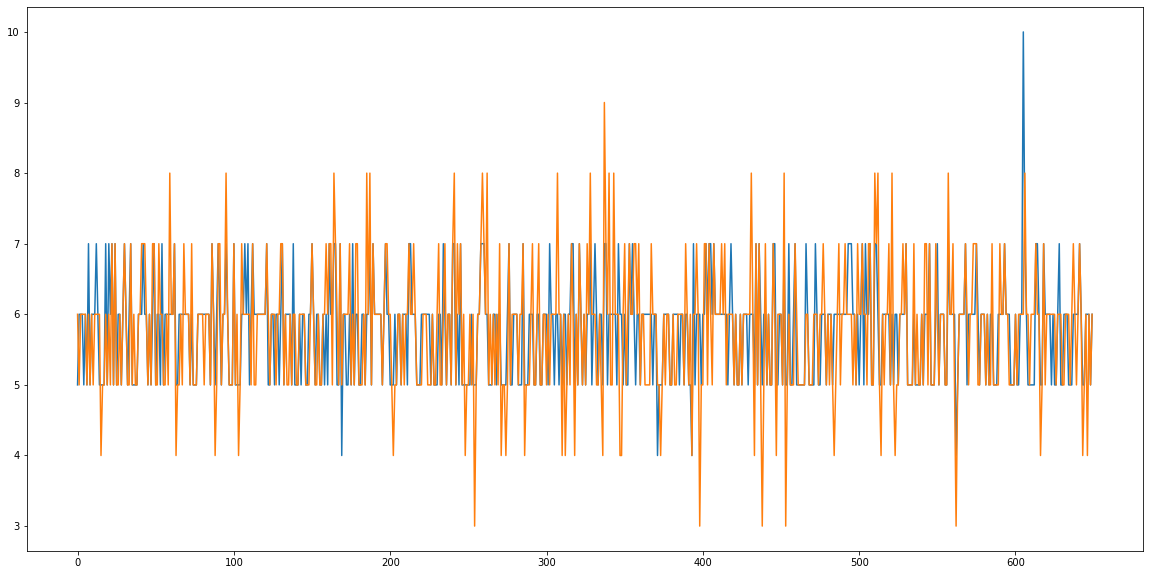

In [31]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for both the training set and the test set.

In [32]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-pred_train_y)**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.1104844830196068
test RMSE 1.1365868140176607


We calculate the R2 score for the predictions on both the training set and the test set. 

Notice that the R2 score is much smaller on the test set, this implies overfitting.

In [33]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  0.5048727772904155
test R2 score:   0.3254242377891632


We calculate the mean absolute percentage error of predictions for both the training set and the test set.

MAPE of 15% points to low but acceptable accuracy. It means that on average, the predicted value is about 15% off the actual value.

In [34]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.14557189818690883 
test MAPE 0.15037578566732407 


Next we calculate how many predictions were accurate (meaning 5 was predicted as 5 etc) in both the training set and the test set. 

We print out the percentage of accurate predictions in the training set, then in the test set.

We see that the training set predictions are 78% accurate, but test set predictions are only 59% accurate, which points to overfitting.

In [35]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print(n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print(n*100/len(pred_y), "%")

66.70087224217548 %
59.38461538461539 %


The question arises how to improve the accuracy of the predictions.

One thing we can try is to make a neural network with a smaller hidden_size = 150.

We are going to try a two layer neural network with two dense layers and ReLU activation function.

In [33]:
num_features = 11
hidden_size = 150
num_classes = 1

The cost function we are trying to minimize is the mean squared error loss used in linear regression.

We use stochastic gradient descent to change weights.

We take the learning rate to be 0.01.

In [65]:
model = TwoLayerNeuralNet(11, 150, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

TwoLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=150, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=150, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We run the optimization for 300000 iterations. Such a large number of iterations poses the risk of overfitting.

In [66]:
list = []
for epoch in range(300000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 34.74192428588867
epoch 10000, cost function 0.4889186918735504
epoch 20000, cost function 0.46684789657592773
epoch 30000, cost function 0.454153835773468
epoch 40000, cost function 0.4446108937263489
epoch 50000, cost function 0.43628010153770447
epoch 60000, cost function 0.42906057834625244
epoch 70000, cost function 0.4223006069660187
epoch 80000, cost function 0.41603970527648926
epoch 90000, cost function 0.41035571694374084
epoch 100000, cost function 0.4049721360206604
epoch 110000, cost function 0.40013501048088074
epoch 120000, cost function 0.3957516551017761
epoch 130000, cost function 0.39177748560905457
epoch 140000, cost function 0.3878769874572754
epoch 150000, cost function 0.3841673731803894
epoch 160000, cost function 0.3808317184448242
epoch 170000, cost function 0.3776724636554718
epoch 180000, cost function 0.37460029125213623
epoch 190000, cost function 0.3715510070323944
epoch 200000, cost function 0.3686191439628601
epoch 210000, cost fu

We graph the cost function as a function of the number of iterations.

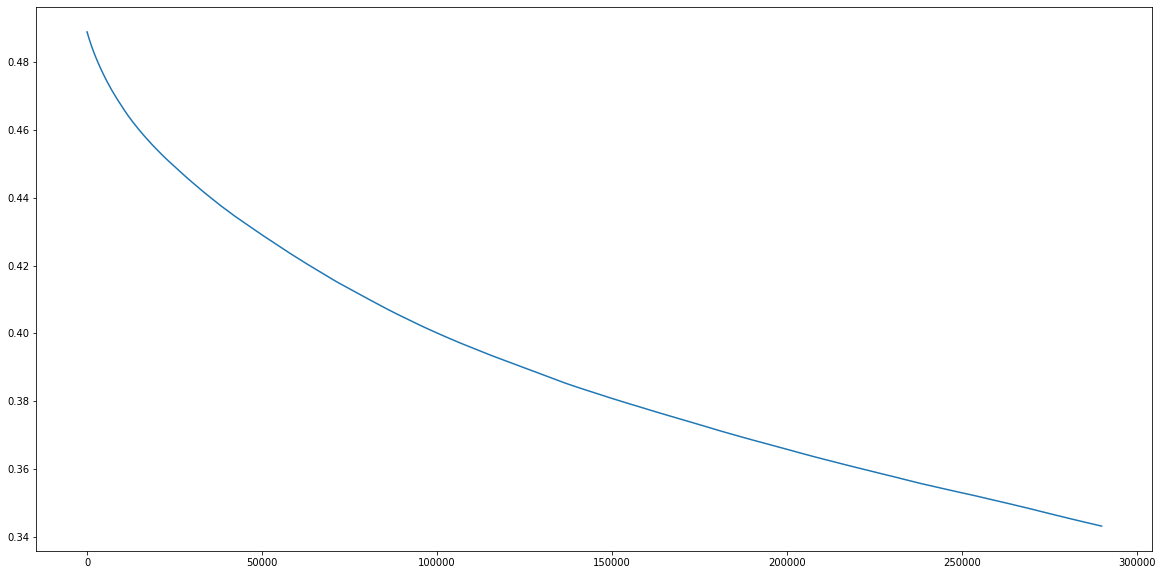

In [67]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We get the predictions of y on the training set of X_data using the final model.

We translate those y values into integers 0 to 9 and store them in numpy array pred_train_y.



In [68]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[6 5 5 ... 6 5 5]


We get the predictions of y on the test set of X (test_x) using the final model.

We translate those y values into integers 0 to 9 and store them in numpy array pred_y.

We the graph both the predicted values of y and actual values of y in the test set.

[6 7 6 6 6 6 7 6 7 5 6 7 5 5 6 5 6 6 5 6 6 7 5 6 6 6 7 6 6 7 5 5 5 4 5 6 5
 6 5 7 5 7 7 7 6 6 7 5 6 5 7 7 5 5 5 6 6 6 7 7 6 5 5 6 6 5 6 6 5 5 6 6 7 5
 5 5 7 6 6 6 7 6 6 6 6 6 6 5 7 5 7 6 5 5 6 6 5 6 6 6 7 5 6 6 5 6 6 6 5 6 7
 7 7 8 6 6 6 5 6 7 5 7 6 7 5 7 5 7 6 5 5 5 5 7 7 6 6 5 5 7 5 5 5 7 6 5 5 6
 7 6 5 6 6 6 5 7 5 7 6 7 6 6 5 6 5 6 7 6 5 5 5 6 6 5 6 6 5 6 6 5 5 5 5 5 6
 5 6 5 6 5 6 5 5 5 7 6 5 6 6 7 5 5 6 7 7 6 5 6 6 5 6 6 5 6 7 6 5 7 5 6 6 6
 6 6 5 6 6 6 6 6 5 6 6 7 7 6 7 5 6 6 5 6 6 6 7 5 7 5 5 7 6 5 6 7 6 6 6 6 5
 6 5 5 5 5 6 5 5 6 6 5 5 6 6 6 6 6 5 6 6 5 5 6 5 7 6 6 6 5 6 7 6 6 5 6 5 6
 5 5 6 6 7 5 7 6 5 7 5 6 6 5 5 6 6 7 6 6 6 6 5 6 6 6 6 6 6 5 5 6 5 6 6 5 6
 6 6 6 6 6 6 5 5 6 7 6 7 6 6 5 6 6 7 5 6 5 6 6 5 5 7 5 7 7 6 7 6 7 7 6 6 5
 7 6 5 5 5 7 5 6 7 6 7 5 6 6 5 6 6 6 5 6 5 6 6 6 6 6 6 7 7 6 6 5 6 6 6 6 7
 6 6 5 5 6 5 6 7 6 6 6 6 7 6 5 6 6 6 6 6 6 6 6 5 6 5 6 7 5 5 5 5 5 6 6 6 6
 6 6 5 6 6 6 6 5 6 6 6 6 5 6 5 6 7 7 6 6 6 6 5 6 5 5 6 5 5 6 7 6 7 6 6 5 6
 5 7 6 7 7 6 6 5 5 7 6 6 

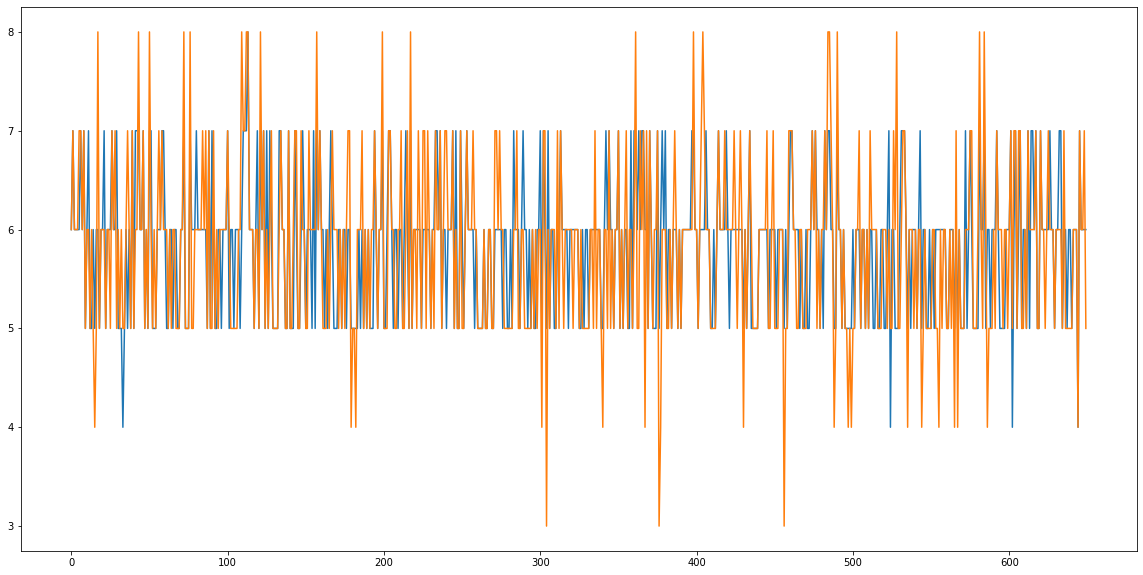

In [69]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for both the training set and the test set predictions.



In [70]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-pred_train_y)**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.1118340792913053
test RMSE 1.1135741274284827


We calculate the R2 score for both the training set and the test set.



In [71]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  0.45403028056843897
test R2 score:   0.33380571658554226


We calculate the percentage of the correct predictions (i.e. 5 predicted as 5) for both the training set and the test set.

In [72]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print("train ", n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print("test ", n*100/len(pred_y), "%")

train  63.74208996066359 %
test  58.30769230769231 %


We calculate mean absolute percentage error of predictions for both the training set and the test set.

In [73]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.14613604011394535 
test MAPE 0.14679353620738228 


We see that decreasing the hidden_size from 500 to 150 decreased the accuracy of the predictions on the test set by about 1%.

We can try if a larger hidden_size = 700 improves the preformance of the model.

In [74]:
model = TwoLayerNeuralNet(11, 700, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

TwoLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=700, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=700, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We run the optimization for 300000 iterations.

In [75]:
list = []
for epoch in range(300000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 38.006324768066406
epoch 10000, cost function 0.4582354724407196
epoch 20000, cost function 0.4364679753780365
epoch 30000, cost function 0.42136308550834656
epoch 40000, cost function 0.4088180363178253
epoch 50000, cost function 0.3979457914829254
epoch 60000, cost function 0.3881990313529968
epoch 70000, cost function 0.3791373670101166
epoch 80000, cost function 0.37038111686706543
epoch 90000, cost function 0.36200806498527527
epoch 100000, cost function 0.35404855012893677
epoch 110000, cost function 0.34639638662338257
epoch 120000, cost function 0.33903393149375916
epoch 130000, cost function 0.3319970369338989
epoch 140000, cost function 0.3252483904361725
epoch 150000, cost function 0.3187570869922638
epoch 160000, cost function 0.3124256432056427
epoch 170000, cost function 0.3063097894191742
epoch 180000, cost function 0.30034658312797546
epoch 190000, cost function 0.29457390308380127
epoch 200000, cost function 0.2890080213546753
epoch 210000, cost 

We graph the cost function as a function of the number of iterations.

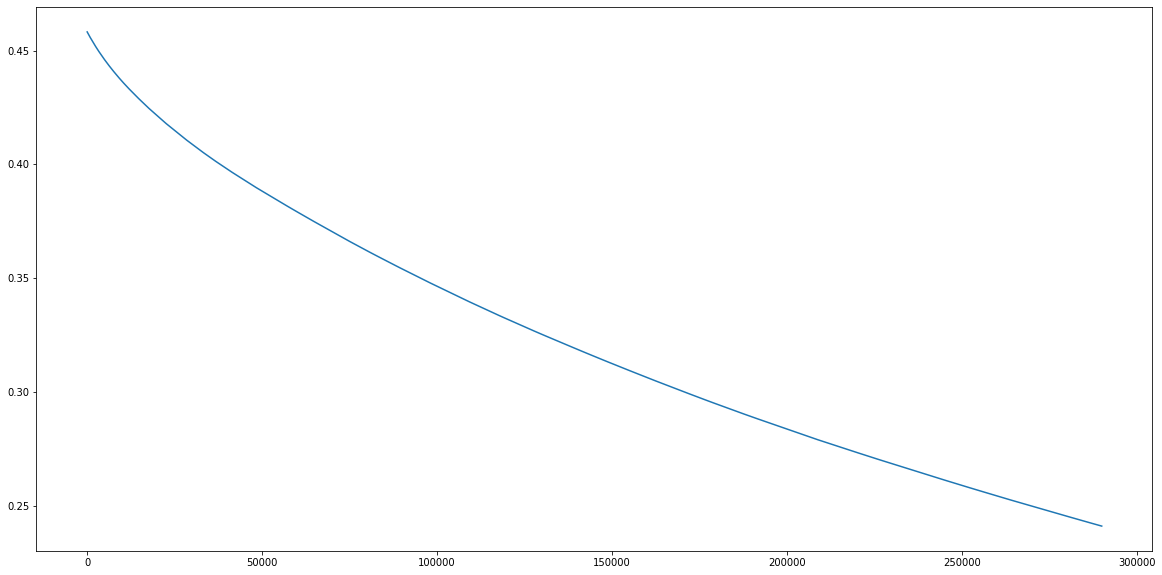

In [76]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We use the final model to predict the training values of y using the training set of X.

We convert the predictions of y into integers 0 to 9 and store them in a numpy array pred_train_y.



In [83]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[ 6  6  4 ... 10  5  5]


We use the final model to predict the test values of y using the test set of X.

We convert the predictions of y into integers 0 to 9 and store them in a numpy array pred_y.

We graph the predicted test values of y and actual test values of y.

[6 6 6 6 5 6 7 6 7 5 6 7 5 5 6 5 6 7 5 5 6 7 5 6 5 6 7 6 6 6 5 5 6 4 5 6 5
 6 5 7 5 6 7 7 6 6 7 5 6 5 6 7 5 6 4 5 7 6 7 7 6 5 5 6 5 6 7 6 6 5 6 6 7 6
 5 5 7 7 6 6 7 6 6 6 6 6 6 5 7 5 6 7 6 6 6 6 5 6 6 6 6 5 6 5 5 6 6 6 5 7 7
 7 7 7 6 5 6 5 6 7 5 7 6 7 5 6 5 7 6 5 5 5 5 6 6 6 6 5 5 7 5 5 5 6 6 5 5 6
 7 6 5 6 6 6 5 6 5 7 6 7 6 6 5 6 5 6 6 6 5 5 6 5 6 5 6 6 6 7 6 5 5 5 5 5 7
 5 6 5 6 5 6 5 6 5 7 6 5 6 6 8 5 5 5 7 7 5 5 6 6 5 6 7 5 6 6 6 5 7 5 5 6 6
 6 6 5 5 6 6 7 5 5 6 6 7 6 6 7 5 7 6 6 5 6 6 7 5 6 5 5 6 6 5 6 7 6 6 7 7 5
 6 5 5 5 5 6 5 5 6 6 5 5 6 6 6 6 6 6 6 5 5 5 6 5 7 6 6 7 5 6 6 6 6 6 6 5 7
 5 6 6 6 7 5 6 7 5 6 5 6 6 5 5 6 5 7 5 6 5 5 5 6 6 6 6 6 6 5 5 6 5 6 6 5 6
 6 6 6 6 6 6 5 6 6 6 5 6 6 6 5 6 6 6 5 6 5 6 7 5 6 6 5 7 7 6 7 6 7 7 6 6 5
 7 6 5 5 7 7 5 6 7 6 7 5 6 6 5 6 6 5 6 6 6 6 6 6 6 6 6 6 7 6 6 5 6 6 7 6 6
 6 6 5 5 6 5 6 7 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 5 6 5 6 7 6 5 5 5 5 5 6 6 6
 6 6 5 6 6 6 6 5 6 6 7 6 5 6 6 6 7 7 6 6 5 5 7 6 5 5 5 6 5 6 7 6 7 6 7 5 6
 5 7 5 8 6 6 6 5 5 7 6 5 

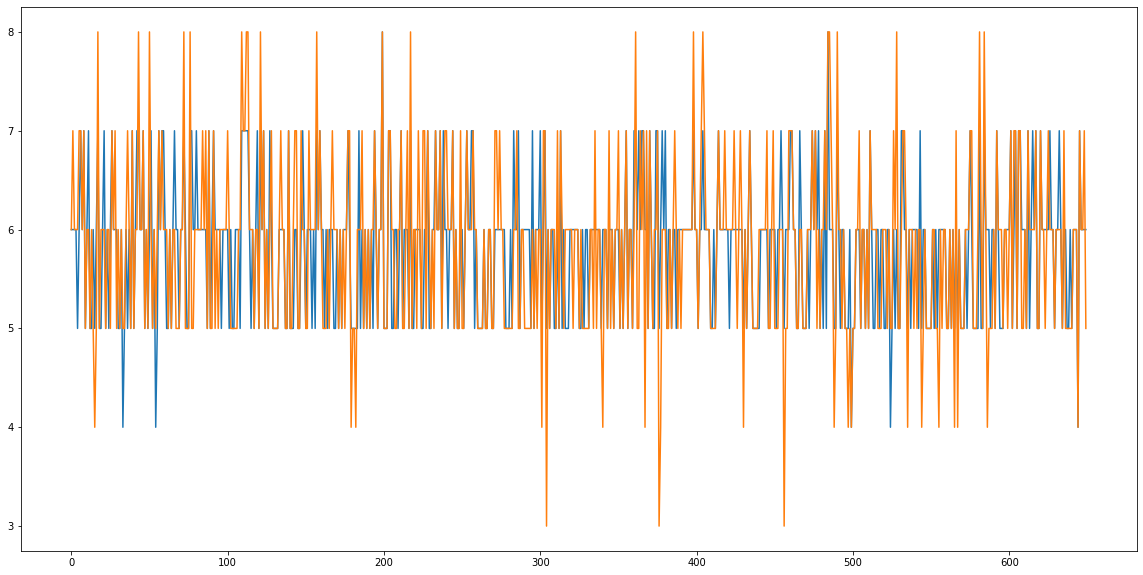

In [78]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for both the training set and the test set predictions.

In [79]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-pred_train_y)**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.880748840605351
test RMSE 1.1130745308570327


We calculate the R2 score for both the training set and the test set predictions.

Notice that the training R2 score is negative, which means that the model does not fit the data.

In [80]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  -1.873112484175517
test R2 score:   0.38109728608718585


We calculate the percentage of the correct predictions for both the training set and the test set. We see that increasing the hidden_size from 500 to 700 gave an almost 2% improvement in the accuracy of the predictions on the test set.

In [81]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print("training ", n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print("test ", n*100/len(pred_y), "%")

training  71.1304942705661 %
test  61.07692307692308 %


We calculate mean absolute percentage error for both the training set and test set predictions.

In [82]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.23118397756431647 
test MAPE 0.14601590588898283 


We see that the two layer neural network performs better than a one layer neural network.

We try to improve performance further by adding more dense layers.

The next model has four dense layers with ReLU activation functions.

In [12]:
class FourLayerNeuralNet(nn.Module):  #fully connected neural network with four hidden layers
    def __init__(self, num_features, hidden_size, num_classes):
        super(FourLayerNeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc2(out)    
        return out 

We take the hidden_size = 400. The first layer of the neural network has 11 input dimensions (number of X columns) and 400 output dimensions. The next two layers both have 400 input dimensions and 400 output dimensions. The fourth layer has 400 input dimensions and 1 output dimension (y data has 1 column).

In [16]:
num_features = 11
hidden_size = 400
num_classes = 1

We minimize the mean squared error cost function as is usual for the regression problems.

To update the weights in the model, we use Stochastic Gradient Descent.

In [17]:
model = FourLayerNeuralNet(11, 400, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

FourLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=400, out_features=1, bias=True)
)


We run the optimization for 200000 iterations.

In [18]:
list = []
for epoch in range(200000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 34.567081451416016
epoch 10000, cost function 0.4290924370288849
epoch 20000, cost function 0.3899105191230774
epoch 30000, cost function 0.35178646445274353
epoch 40000, cost function 0.3119889497756958
epoch 50000, cost function 0.2719114124774933
epoch 60000, cost function 0.23175852000713348
epoch 70000, cost function 0.19324979186058044
epoch 80000, cost function 0.19374464452266693
epoch 90000, cost function 0.17705442011356354
epoch 100000, cost function 0.16875103116035461
epoch 110000, cost function 0.14387281239032745
epoch 120000, cost function 0.13614904880523682
epoch 130000, cost function 0.12394393980503082
epoch 140000, cost function 0.11510290950536728
epoch 150000, cost function 0.10239499807357788
epoch 160000, cost function 0.110987089574337
epoch 170000, cost function 0.10292275995016098
epoch 180000, cost function 0.0797378197312355
epoch 190000, cost function 0.09047716110944748


We graph the loss function as a function of the number of iterations.

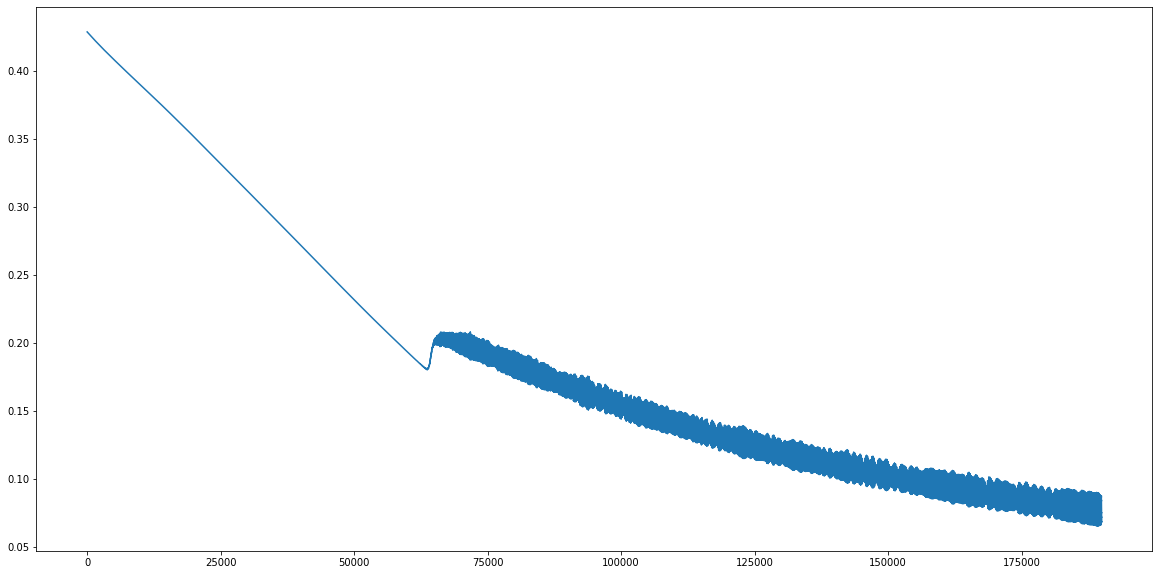

In [19]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We get the predictions of the training set of y values using the final model applied to the training set of X values.

The predictions are then translated into integers 0 to 9.

In [20]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(train_y)

[6 5 6 ... 6 7 6]


We use the final model to predict the test values of y using the test values of X.

We translate the predictions into integers 0 to 9.

We graph both the predicted values pred_y and the actual values test_y.

[ 5  6  6  6  5  6  5  8  5  6  6  6  7  6  6  5  5  5  7  5  7  7  6  5
  7  5  6  5  5  6  6  6  5  6  7  6  5  5  5  7  6  7  6  6  6  6  6  6
  6  7  5  5  7  6  6  5  5  6  7  6  6  7  7  4  5  6  6  6  7  6  5  5
  6  6  5  5  5  6  7  6  6  5  7  6  6  5  7  7  5  6  6  6  5  6  6  7
  6  6  5  5  7  5  5  5  6  7  6  6  6  7  6  5  8  6  6  6  6  6  6  5
  6  7  5  5  6  6  5  6  6  5  6  7  5  6  5  6  6  5  7  6  5  6  6  5
  6  6  6  5  6  5  7  6  5  5  7  5  5  6  5  7  6  7  7  6  8  7  5  5
  8  5  6  6  5  6  6  5  6  5  5  7  5  6  5  6  6  8  7  8  5  7  6  6
  6  6  6  6  6  8  6  6  6  6  5  7  5  6  6  6  6  6  6  6  7  6  6  7
  6  6  5  5  5  6  6  6  6  5  6  6  5  6  6  7  5  6  7  6  5  6  6  5
  7  7  4  6  6  7  5  5  5  5  5  6  6  5  6  5  6  6  7  8  7  5  6  5
  6  6  6  6  5  7  7  4  6  5  4  5  7  5  5  6  6  6  6  5  6  7  6  5
  5  6  6  5  5  5  5  7  5  5  6  6  5  4  7  6  6  7  5  7  6  6  5  7
  8  5  8  5  7  6  5  6  5  7  6  5  6  5  7  6  8

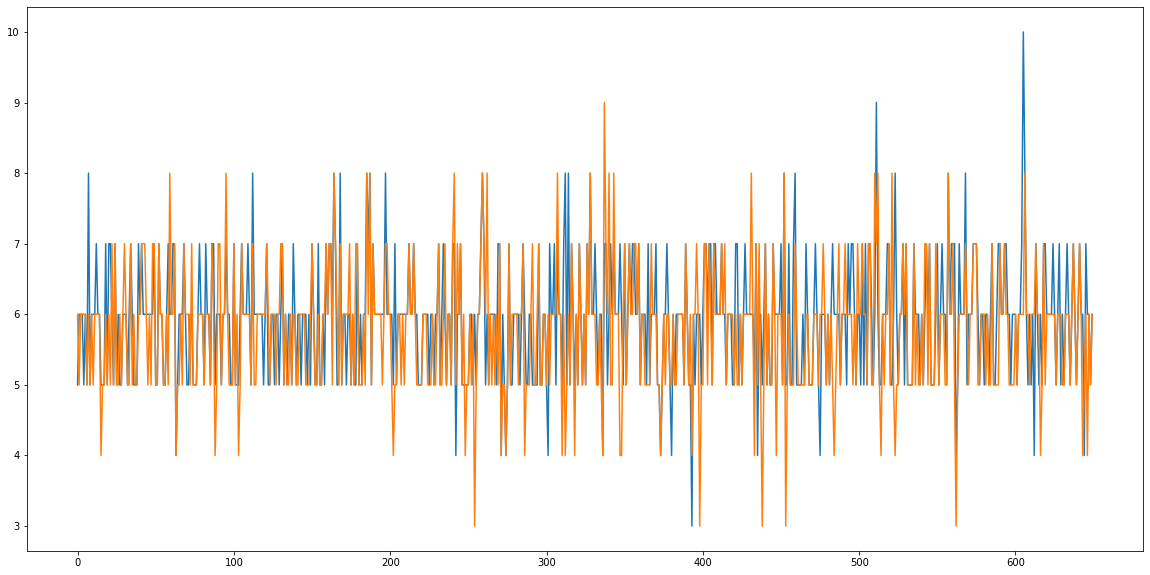

In [21]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for the predicted values of y for the training set and the test set.

In [22]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-pred_train_y)**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.221611736073019
test RMSE 1.242305548938375


We get the R2 scores for the predicted values of y for the training set and the test set.

In [23]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  0.9266895911705626
test R2 score:   0.16545341417916481


We calculate the percentage of correct predictions for both the training set and the test set.

We see that the training set has 94.5% correct predictions, but the test set has 62.77% correct predictions, implying that the model overfits the data.

In [24]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print(n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print(n*100/len(pred_y), "%")

94.49290234308192 %
62.76923076923077 %


We calculate the mean absolute percentage error. Both the training set and the test set have MAPE about 16%, which means that the accuracy is low but acceptable.

In [25]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.1622119746548278 
test MAPE 0.1683165004226543 


Another question is whether adding more layers to the neural network would improve the accuracy of the predictions.

We can try six dense layers with ReLU activation functions.

In [84]:
class SixLayerNeuralNet(nn.Module):  #fully connected neural network with one hidden layer
    def __init__(self, num_features, hidden_size, num_classes):
        super(SixLayerNeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        out = self.relu(out)
        out = self.fc2(out)    
        return out 


We take hidden_size = 300. The first layer has input dimension 11 (as in number of X columns) and output dimension 300. The last layer has input dimension 300 and output dimension 1 (y has one column). The middle layers have both input and output dimensions equal to 300.

In [85]:
num_features = 11
hidden_size = 300
num_classes = 1

We minimize the cost function using the mean squared error loss criterion.

To update the weights in the model, we use Stochastic Gradient Descent optimizer.

The learning rate is 0.002.

In [86]:
model = SixLayerNeuralNet(11, 300, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)
print(model)

SixLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (fc5): Linear(in_features=300, out_features=300, bias=True)
  (fc6): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=300, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We run the optimization for 200000 iterations.

In [87]:
list = []
for epoch in range(200000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 35.077232360839844
epoch 10000, cost function 0.3831188976764679
epoch 20000, cost function 0.32095277309417725
epoch 30000, cost function 0.2639070153236389
epoch 40000, cost function 0.19982825219631195
epoch 50000, cost function 0.14986266195774078
epoch 60000, cost function 0.10782095789909363
epoch 70000, cost function 0.16534748673439026
epoch 80000, cost function 0.06846024096012115
epoch 90000, cost function 0.11867722868919373
epoch 100000, cost function 0.0682307705283165
epoch 110000, cost function 0.03440552204847336
epoch 120000, cost function 0.03616156429052353
epoch 130000, cost function 0.054190658032894135
epoch 140000, cost function 0.017547979950904846
epoch 150000, cost function 0.029462354257702827
epoch 160000, cost function 0.021141359582543373
epoch 170000, cost function 0.048991620540618896
epoch 180000, cost function 0.010326983407139778
epoch 190000, cost function 0.014365089125931263


We plot the cost function as a function of the number of iterations.

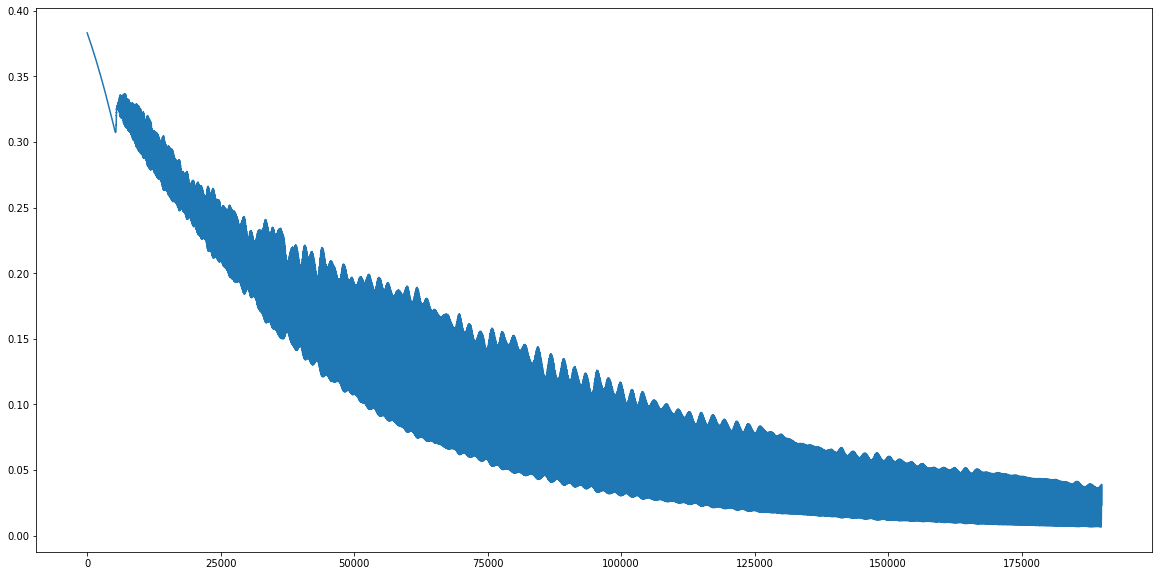

In [88]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We use the final model to predict y using training X data. We call the predicted values model_train_y. We replace predicted y with the closest integer and store the results in numpy array pred_train_y.

In [95]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[6 5 4 ... 5 6 5]


Then we use the final model to predict test set of y using the test set of X. We replace predicted y with the closest integer and store the results in numpy array pred_y. We graph both the predicted test values and the actual test values of y.

[6 6 6 6 6 7 7 6 7 5 6 7 5 6 7 5 6 8 6 6 6 6 5 7 5 5 8 6 7 8 5 5 6 5 6 6 6
 6 5 7 5 6 7 8 6 6 7 5 6 5 7 7 5 6 5 5 6 7 7 7 6 5 5 6 5 6 6 5 5 5 6 6 7 4
 5 5 9 6 6 6 6 6 6 7 7 6 7 5 7 5 6 7 6 6 6 6 5 6 6 6 7 6 5 5 5 6 6 6 5 8 7
 7 7 8 7 6 6 6 6 6 5 8 6 7 6 7 5 7 7 5 6 5 5 6 6 6 6 5 5 7 5 4 5 7 7 5 5 7
 6 7 5 6 6 6 5 6 6 7 6 7 6 6 5 6 5 7 6 7 5 6 6 6 6 5 7 5 6 7 7 4 5 5 5 5 7
 6 6 5 5 5 6 5 6 5 7 6 6 6 7 8 5 5 5 7 8 6 5 5 6 6 5 7 5 5 6 6 4 8 5 5 6 5
 6 6 5 6 7 6 7 6 4 6 6 7 6 6 7 6 7 5 6 6 5 6 7 5 7 5 5 7 6 6 6 7 6 6 7 7 5
 6 6 5 5 5 8 6 5 6 6 5 5 6 7 6 6 7 6 6 5 5 5 7 5 8 6 7 7 5 6 6 5 5 6 6 5 6
 5 6 7 6 7 5 7 7 5 5 6 6 6 5 5 7 5 7 6 5 5 6 6 8 6 6 6 6 5 5 5 5 5 5 7 6 6
 6 6 7 6 5 6 5 4 5 6 5 6 6 6 5 6 6 6 6 6 6 6 7 5 6 5 5 6 8 6 7 6 6 6 6 7 5
 7 5 6 6 6 7 6 5 6 7 6 5 6 6 5 6 7 5 5 6 6 6 6 6 6 6 6 6 7 6 6 6 5 6 8 7 7
 6 6 5 6 6 5 6 7 6 6 6 6 6 6 5 6 6 6 6 6 7 6 6 5 7 5 6 7 6 6 6 5 5 6 7 7 6
 6 7 5 6 6 7 6 5 5 6 7 7 7 5 5 6 7 7 6 6 5 5 6 6 5 5 5 6 5 6 7 6 7 5 7 5 7
 6 7 6 8 7 6 6 5 5 7 6 5 

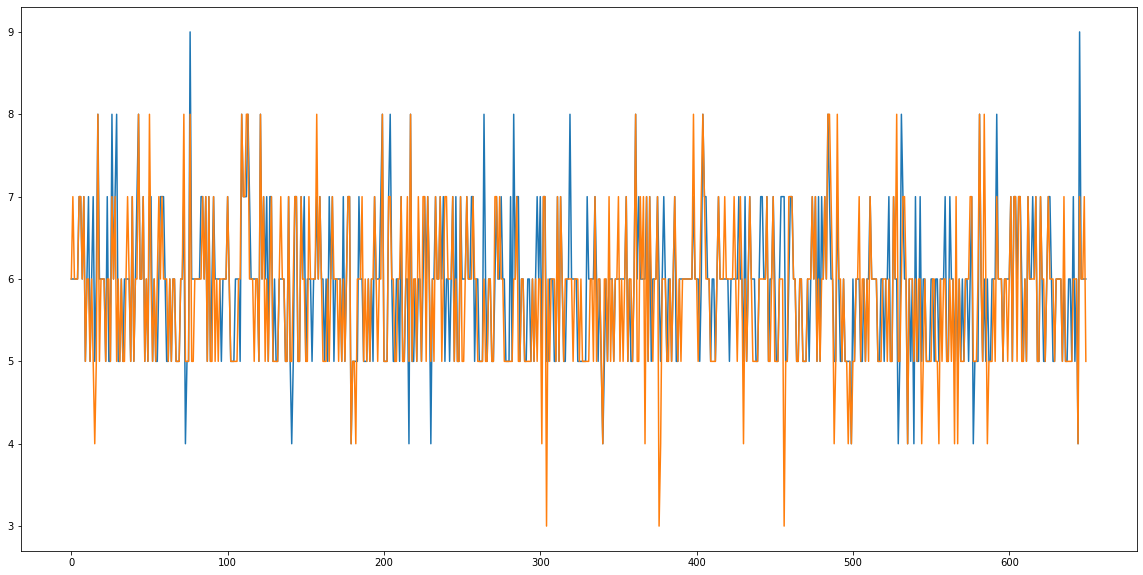

In [90]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for both the training set predictions and the test set predictions.

In [91]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-pred_train_y)**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.2353511827706496
test RMSE 1.2089508386107


We calculate the R2 score for both the training set predictions and the test set predictions.



In [92]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  0.9937322049429751
test R2 score:   0.36053573412994944


We notice that the R2 score of the test set is much smaller than the R2 score of the training set. This is a sign of overfitting the data.

Next we calculate the percentage of the accurate predictions for the training set and the test set.

In [93]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print(n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print(n*100/len(pred_y), "%")

99.52112194287669 %
65.23076923076923 %


The accuracy of the predictions on the training set is 99.52% and the accuracy of the predictions on the test set is 65.23%. This implies that the neural network overfits the model. However, this is the highest accuracy on the test set, which means that multilayer neural networks with large size of hidden layers works better than neural networks with fewer layers.

We find the mean absolute percentage error for the predictions on the training set and the test set.

Since in both cases MAPE is 16%, the accuracy is low but acceptable.

In [94]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.16342904850758172 
test MAPE 0.16087811496196108 


To compare the results, we try a six layer model with the size of hidden layers equal 100. 

In [42]:
model = SixLayerNeuralNet(11, 100, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

SixLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We optimize the model for 200000 iterations.

In [43]:
list = []
for epoch in range(200000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 5000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 34.004703521728516
epoch 5000, cost function 0.4885229766368866
epoch 10000, cost function 0.46092450618743896
epoch 15000, cost function 0.4429098069667816
epoch 20000, cost function 0.42738932371139526
epoch 25000, cost function 0.41337236762046814
epoch 30000, cost function 0.39969784021377563
epoch 35000, cost function 0.3846697509288788
epoch 40000, cost function 0.36859187483787537
epoch 45000, cost function 0.3502369225025177
epoch 50000, cost function 0.33023953437805176
epoch 55000, cost function 0.30869778990745544
epoch 60000, cost function 0.28688836097717285
epoch 65000, cost function 0.2650454342365265
epoch 70000, cost function 0.24252110719680786
epoch 75000, cost function 0.24043099582195282
epoch 80000, cost function 0.22608883678913116
epoch 85000, cost function 0.2450380027294159
epoch 90000, cost function 0.20391133427619934
epoch 95000, cost function 0.22633329033851624
epoch 100000, cost function 0.18985968828201294
epoch 105000, cost funct

We plot the cost function as a function of the number of iterations.

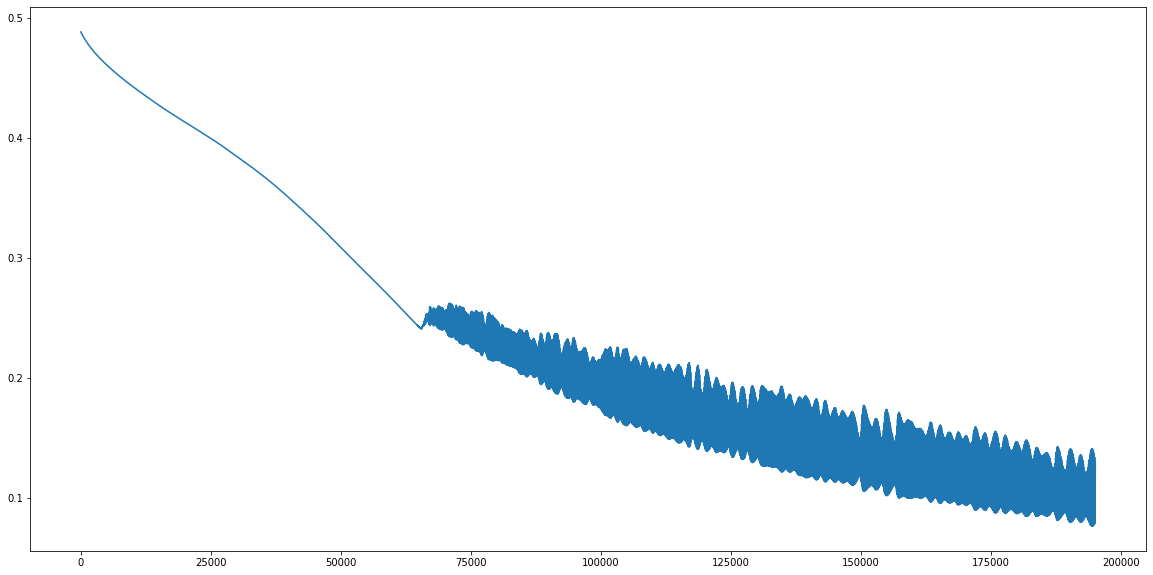

In [44]:
plt.figure(figsize = (20,10))
plt.plot(list[5000:])

We use the final model to predict the y data for the training set using the X data for the training set.

We translate the predicted values into integers 0 to 9, so that it is easier to compare the predictions to the actual values of y.

In [45]:
#this is how predicted values of y look if they are not translated to integers 0 to 9.
train_y = model(X_data)
print(train_y)

tensor([[6.2524],
        [5.6979],
        [4.3740],
        ...,
        [5.2460],
        [6.2837],
        [5.1247]], grad_fn=<AddmmBackward0>)


In [46]:
model_train_y = model(X_data)
pred_train_y = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 8
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[6 6 4 ... 5 6 5]


Next, we use the final model to predict the y data for the test set using the X data for the test set.

We translate the predicted values into integers 0 to 9, so that it is easier to compare the predictions to the actual values of y.

We graph the predicted test values of y and the actual test values of y.

[6 6 8 6 6 6 7 6 7 5 6 7 6 6 7 5 6 7 6 5 6 7 5 6 6 5 8 7 7 7 6 5 6 5 6 7 5
 6 5 7 5 6 8 8 6 7 8 6 6 5 7 8 5 6 5 4 6 6 7 6 6 5 5 7 6 6 7 5 6 5 6 7 8 6
 5 6 8 7 6 6 7 6 6 7 6 6 7 6 8 5 7 7 6 6 6 6 5 6 6 6 7 6 6 5 5 7 6 6 6 8 7
 7 7 8 6 5 6 6 6 8 5 8 6 7 5 6 5 9 7 6 5 5 5 8 5 6 6 5 6 8 5 6 5 7 7 5 6 7
 7 6 5 7 6 6 5 6 6 7 6 7 6 6 5 5 5 6 7 6 5 6 6 5 6 5 7 6 6 7 6 5 5 5 4 5 6
 6 7 5 5 5 6 5 6 5 7 7 6 6 6 8 5 5 6 8 7 5 5 5 7 6 6 7 5 5 6 7 5 8 5 5 5 5
 6 6 5 6 6 7 7 6 5 6 6 7 6 6 7 6 7 6 6 6 6 6 7 5 7 6 5 7 6 5 6 8 6 7 7 8 5
 6 6 5 5 5 7 5 5 5 6 5 5 6 7 6 7 6 5 6 5 5 5 6 5 7 7 7 6 5 6 7 5 6 6 6 5 7
 6 6 7 6 7 6 7 7 6 6 6 5 6 6 5 7 6 7 6 5 6 6 6 8 6 7 6 6 6 5 5 6 5 6 7 5 6
 5 6 7 5 6 7 6 5 5 6 5 6 6 6 5 7 6 6 5 7 6 6 8 6 6 7 5 7 8 5 7 8 6 7 7 7 5
 8 6 5 6 5 7 6 6 7 7 5 5 5 6 5 6 7 5 5 6 6 6 6 6 6 6 6 6 7 6 6 6 5 6 8 7 7
 7 6 5 5 6 5 7 7 6 6 6 7 6 6 6 6 6 6 7 6 7 7 5 5 6 5 6 7 5 5 5 6 5 6 7 7 6
 6 7 6 7 6 7 6 5 6 6 7 6 5 6 5 5 7 7 6 6 5 6 5 6 5 5 5 6 5 6 8 6 7 5 7 5 6
 6 7 6 8 7 6 6 5 5 7 6 5 

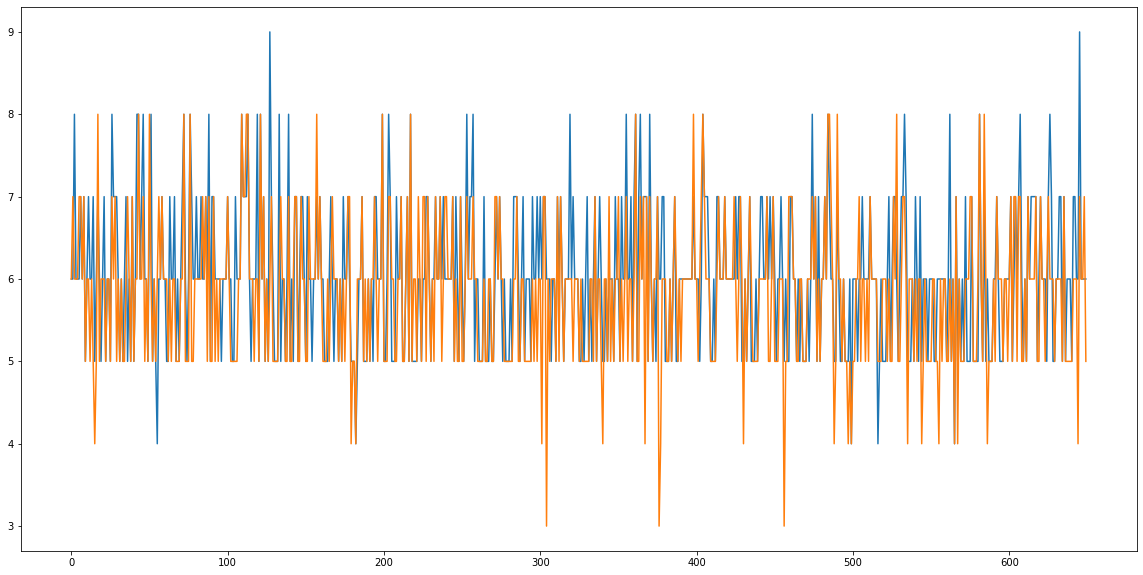

In [47]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error for the training set and the test set predictions.

In [48]:
print("train RMSE {}".format(np.sqrt(np.mean((pred_train_y-y_data.detach().numpy())**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.230971862497667
test RMSE 1.2495338775890006


We calculate the R2 score for both the training set and the test set predictions.

In [49]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  0.8191293426401389
test R2 score:   0.15286405936186231


We calculate the percentage of the correct predictions for both the training set and the test set.

In [50]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print("training ", n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print("test ", n*100/len(pred_y), "%")

86.33487258423123 %
57.23076923076923 %


We see that both the accuracy of the predictions of the six layer neural network with hidden_size = 100 on the training set and on the test set is smaller (by 13% on the training set and by 8% on the test set) than the accuracy of the predictions for the six layer neural network with the hidden_size = 300. This means that the hidden_size plays a significant role in making the predictions more accurate.

We calculate the mean absolute percentage error for both the training set and the test set predictions.

In [51]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.16518899459841863 
test MAPE 0.16861326007326005 


Another question we can ask is if a neural network with a large number of layers but a small hidden_size predicts as well as a neural network with fewer layers but a large hidden_size.

To that end, we construct a neural network with eight dense layers and ReLU activation functions.

In [52]:
class EightLayerNeuralNet(nn.Module):  #fully connected neural network with eight hidden layers
    def __init__(self, num_features, hidden_size, num_classes):
        super(EightLayerNeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        out = self.relu(out)
        out = self.fc7(out)
        out = self.relu(out)
        out = self.fc8(out)
        out = self.relu(out)    
        out = self.fc2(out)
        return out 

We take the hidden_size to be 28. 

We use the mean squared error criterion for minimizing the cost function.

We use the Stochastic Gradient Descent Method to update the weights at each iteration.

In [53]:
model = EightLayerNeuralNet(11, 28, 1)
criterion = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)
print(model)

EightLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=28, bias=True)
  (fc3): Linear(in_features=28, out_features=28, bias=True)
  (fc4): Linear(in_features=28, out_features=28, bias=True)
  (fc5): Linear(in_features=28, out_features=28, bias=True)
  (fc6): Linear(in_features=28, out_features=28, bias=True)
  (fc7): Linear(in_features=28, out_features=28, bias=True)
  (fc8): Linear(in_features=28, out_features=28, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=28, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We optimize the model weights for 200000 iterations.

In [54]:
list = []
for epoch in range(200000):
    loss_epoch = 0
    predict_y = model(X_data)
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 33.02404022216797
epoch 10000, cost function 0.487087219953537
epoch 20000, cost function 0.43982791900634766
epoch 30000, cost function 0.4094851613044739
epoch 40000, cost function 0.38507673144340515
epoch 50000, cost function 0.36420443654060364
epoch 60000, cost function 0.3470146358013153
epoch 70000, cost function 0.3353109359741211
epoch 80000, cost function 0.3317393958568573
epoch 90000, cost function 0.3154431879520416
epoch 100000, cost function 0.311726838350296
epoch 110000, cost function 0.3019884526729584
epoch 120000, cost function 0.2889755070209503
epoch 130000, cost function 0.29969367384910583
epoch 140000, cost function 0.28434279561042786
epoch 150000, cost function 0.27526792883872986
epoch 160000, cost function 0.2793169319629669
epoch 170000, cost function 0.2620238661766052
epoch 180000, cost function 0.26387274265289307
epoch 190000, cost function 0.2566501200199127


We graph the cost function as a function of the number of iterations.

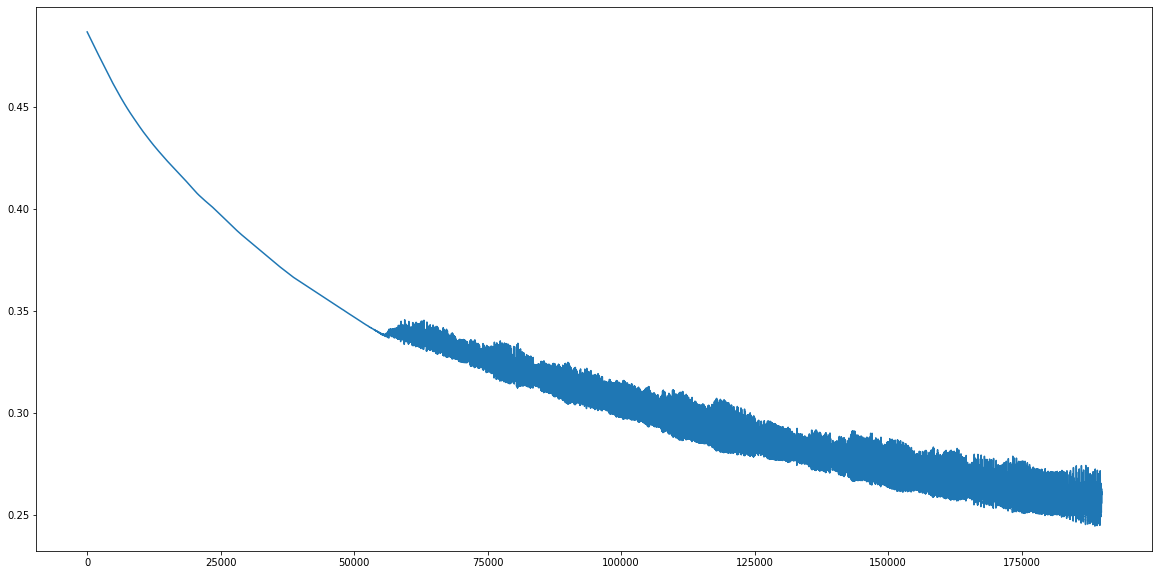

In [55]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We predict the training y values using the training set of X and the final model.

We translate the predictions into integers 0 to 9.

In [56]:
model_train_y = model(X_data)
y_train = [0]*len(model_train_y)
for i in range(len(model_train_y)):
    if model_train_y[i] < 0.5:
        y_train[i] = 0
    elif 0.5 <= model_train_y[i] < 1.5:
        y_train[i] = 1
    elif 1.5 <= model_train_y[i] < 2.5:
        y_train[i] = 2
    elif 2.5 <= model_train_y[i] < 3.5:
        y_train[i] = 3
    elif 3.5 <= model_train_y[i] < 4.5:
        y_train[i] = 4
    elif 4.5 <= model_train_y[i] < 5.5:
        y_train[i] = 5
    elif 5.5 <= model_train_y[i] < 6.5:
        y_train[i] = 6
    elif 6.5 <= model_train_y[i] < 7.5:
        y_train[i] = 7
    elif 7.5 <= model_train_y[i] < 8.5:
        y_train[i] = 7
    elif 8.5 <= model_train_y[i] < 9.5:
        y_train[i] = 9
    else:
        y_train[i] = 10
pred_train_y = np.array(y_train)
print(pred_train_y)

[6 5 4 ... 5 6 5]


We predict the test values of y using the test data of X and the final model. 

We translate the predictions into integers 0 to 9.

We graph both the predicted y and the actual test values of y.

[6 6 6 6 6 6 6 5 7 5 5 7 5 5 5 5 6 7 6 6 5 5 5 6 5 5 7 6 6 6 6 5 6 4 5 7 5
 6 5 7 5 5 7 7 6 6 7 5 5 5 7 7 5 6 5 5 7 7 6 6 6 4 5 6 5 6 6 6 5 4 5 6 6 5
 5 5 7 6 5 6 7 6 6 6 6 6 6 5 7 5 6 7 6 6 6 5 5 6 6 6 6 5 6 5 5 6 6 6 5 7 6
 7 7 8 6 6 7 6 5 7 5 7 6 7 6 6 5 7 6 5 5 5 5 6 6 6 6 5 6 7 5 5 5 7 7 5 5 7
 7 6 5 6 6 6 5 6 5 6 6 7 6 5 5 5 5 6 6 6 5 6 5 5 5 5 6 6 5 7 6 4 5 5 5 5 6
 5 6 5 6 5 6 5 5 5 6 6 5 6 5 7 5 5 5 7 7 5 6 6 6 5 6 6 5 6 6 6 5 7 5 6 5 5
 6 6 5 5 6 6 7 6 5 5 5 6 6 6 6 5 7 6 6 6 6 6 6 5 7 5 5 7 6 5 6 7 6 6 7 7 5
 6 5 5 5 5 6 5 5 5 6 5 5 6 6 6 6 6 5 6 5 5 5 7 5 7 6 5 5 5 7 6 7 5 5 6 5 7
 5 5 5 6 7 5 7 7 5 7 6 6 6 5 5 6 5 6 6 5 6 5 5 6 6 5 6 5 6 5 5 5 5 6 6 5 6
 6 5 7 5 6 7 5 6 6 6 5 7 6 6 5 6 6 7 5 6 5 5 7 5 5 7 5 7 8 6 6 6 7 6 6 6 5
 8 5 5 5 5 7 5 5 7 7 6 5 6 6 5 6 6 5 4 6 6 6 6 6 5 6 6 6 7 6 6 5 6 6 7 6 6
 6 6 5 5 6 5 6 7 6 6 5 6 6 6 5 6 5 6 5 5 6 6 5 5 6 5 6 7 6 5 5 5 5 5 6 6 5
 6 6 5 6 5 7 6 5 6 6 6 7 5 5 5 6 7 7 5 6 5 5 5 5 5 5 5 5 5 5 7 6 7 6 7 5 6
 5 7 6 7 6 6 6 4 5 6 6 5 

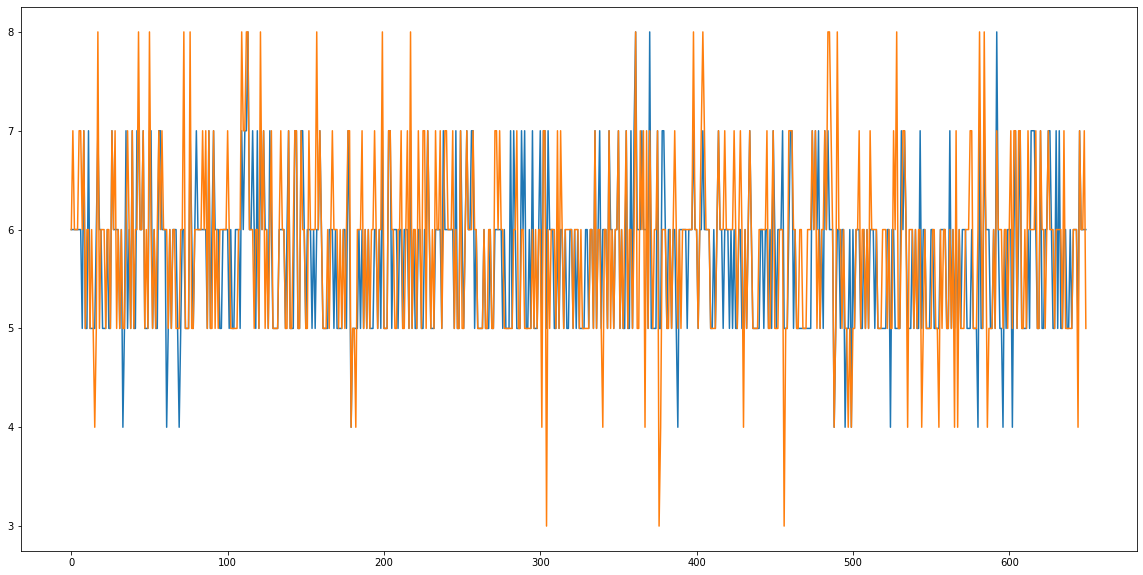

In [57]:
X_test = Variable(torch.Tensor(np.array(test_x).reshape(650,11)))
pred_y = model(X_test)
y_test = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_test[i] = 0
    elif 0.5 <= pred_y[i] < 1.5:
        y_test[i] = 1
    elif 1.5 <= pred_y[i] < 2.5:
        y_test[i] = 2
    elif 2.5 <= pred_y[i] < 3.5:
        y_test[i] = 3
    elif 3.5 <= pred_y[i] < 4.5:
        y_test[i] = 4
    elif 4.5 <= pred_y[i] < 5.5:
        y_test[i] = 5
    elif 5.5 <= pred_y[i] < 6.5:
        y_test[i] = 6
    elif 6.5 <= pred_y[i] < 7.5:
        y_test[i] = 7
    elif 7.5 <= pred_y[i] < 8.5:
        y_test[i] = 8
    elif 8.5 <= pred_y[i] < 9.5:
        y_test[i] = 9
    else:
        y_test[i] = 10
pred_y = np.array(y_test)
print(pred_y.flatten())
plt.figure(figsize = (20,10))
plt.plot(pred_y)
plt.plot(test_y)

We calculate the root mean squared error on both the training set and the test set of predictions. 

In [58]:
print("train RMSE {}".format(np.sqrt(np.mean((y_data.detach().numpy()-pred_train_y)**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-test_y.detach().numpy())**2))))

train RMSE 1.1509450601536064
test RMSE 1.1520848095014635


We calculate the R2 score for the predictions on both the training set and the test set.

In [59]:
print("train R2 score: ", r2_score( y_data.detach().numpy(), pred_train_y))
print("test R2 score:  ", r2_score( test_y.detach().numpy(), pred_y))

train R2 score:  0.5625974449490487
test R2 score:   0.2885703022796222


We calculate the percentage of the correct predictions for both the training set and the test set.

Since 56.3% of correct predictions on the test set is lower than for other examples of neural networks we have considered, we conclude that smaller hidden_size decreases accuracy of predictions.

In [60]:
n1 = 0
for i in range(len(pred_train_y)):
    if pred_train_y[i] - y_data.detach().numpy()[i] == 0:
        n1 += 1
print(n1*100/len(pred_train_y), "%")
n = 0
for i in range(len(pred_y)):
    if pred_y[i] - test_y.detach().numpy()[i] == 0:
        n += 1
print(n*100/len(pred_y), "%")

69.12946810330084 %
56.30769230769231 %


We calculate the mean absolute percentage error for both the training set and the test set predictions.

MAPE of 15% points to low but acceptable accuracy.

In [61]:
print("train MAPE {} ".format(np.mean(np.abs((pred_train_y-y_data.detach().numpy())/y_data.detach().numpy()))))
print("test MAPE {} ".format(np.mean(np.abs((pred_y-test_y.detach().numpy())/test_y.detach().numpy()))))

train MAPE 0.1496602891860078 
test MAPE 0.14961793181177796 


Conclusion:  The most accurate predictions come from the neural networks with large number of hidden layers and a large size of hidden layers. For example a six layer neural network with hidden_size = 300 has 65.23% accuracy of prediction on the test set, and a four layer neural network with hidden_size = 400 has 62.77% accuracy of prediction on the test set.

Two layer neural network with hidden_size = 150 performs better on the test data than an eight layer neural network with hidden_size = 28. Larger hidden size has more influence on accuracy than the number of layers.